In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, TwoSlopeNorm, CenteredNorm
from dask.distributed import Client
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/home/563/sc1326/repos/cdrmip_extremes')
from cdrmip_extremes.configs import data_dir, models, expts
from cdrmip_extremes import load_data, sat, utils

In [2]:
client = Client(memory_limit=None,threads_per_worker=1,n_workers=28)

## Load SAT and GSAT data ##

In [3]:
gsat = load_data.load_gsat()

In [4]:
for model, gsat_data in gsat.items():
    gsat[model] = gsat_data.assign_coords({'model':model}).groupby('time.year').mean(dim='time')
gsat_da = xr.concat(list(gsat.values()),dim='model',
                   compat='override',
                   coords='minimal')
gsat_da

<xarray.DataArray 'gsat' (model: 8, year: 790)> Size: 51kB
array([[-0.30635222, -0.1257577 , -0.13592577, ...,         nan,
                nan,         nan],
       [ 0.0290605 ,  0.08083222,  0.03150065, ...,         nan,
                nan,         nan],
       [-0.2312265 , -0.10835579, -0.10032398, ...,         nan,
                nan,         nan],
       ...,
       [-0.01789575,  0.08388786, -0.10453433, ...,         nan,
                nan,         nan],
       [ 0.05382796,  0.10410298,  0.193953  , ...,         nan,
                nan,         nan],
       [ 0.38933968,  0.25056091,  0.24847846, ...,  0.84634734,
         0.79709729,  0.82651592]])
Coordinates:
  * year     (year) int64 6kB 0 1 2 3 4 5 6 7 ... 783 784 785 786 787 788 789
  * model    (model) <U13 416B 'ACCESS-ESM1-5' 'CanESM5' ... 'UKESM1-0-LL'

In [5]:
gwl_years = load_data.load_gwl_years()

In [6]:
sat_diff = load_data.load_sat_difference('tas_15')

In [7]:
# load co2 series
path = os.path.join(data_dir,'processed/co2/co2.nc')
CO2 = xr.open_dataset(path).rename(
    {'__xarray_dataarray_variable__':'CO2'}
).CO2


## Calculate Multi-Model Median SAT Change and Model Agreement ##

In [8]:
sat_diff_agreement = utils.calc_agreement(sat_diff)

In [9]:
sat_diff_da = xr.concat(
    list(sat_diff.values()),
    dim='model',
    compat='override',
    coords='minimal'
)
sat_diff['Multi-Model Median'] = sat_diff_da.median(dim='model')

## Plot ##

In [10]:
# define colour scheme
colours = ['forestgreen','orange','blue','red','purple','springgreen','pink','dodgerblue']
colour_dict = {model:colours[i] for i, model in enumerate(models)}

In [11]:
def plot_gmst_and_gwls(gmst_da,gwl_years,fig,ax):

    for model in models:
        da = gmst_da.sel(model=model)
        da_rolling = da.rolling(year=21,center=True,min_periods=1).mean()
        da.plot(ax=ax,color=colour_dict[model],linewidth=2,alpha=0.3)
        da_rolling.plot(ax=ax,label=model,color=colour_dict[model],linewidth=2)

        # plot 1.5 crossing year
        gwl_up = gwl_years[model].sel(branch='ramp_up').sel(gwl=1.5)
        gwl_down = gwl_years[model].sel(branch='ramp_down').sel(gwl=1.5)

        ax.scatter(
            gwl_up,
            gwl_up.gwl,
           marker='^',
          color=colour_dict[model],
          s=400,
          # label='1.5$^o$C ramp-up'
            zorder=10
        )
        ax.scatter(gwl_down,
           gwl_down.gwl,
           marker='v',
          color=colour_dict[model],
          s=400,
          # label='1.5$^o$C ramp-down'
        zorder=10
                  )
    
    ax.set_ylabel('GSAT Anomaly (°C)',fontsize=18)
    ax.set_xlim([0,345])
    x_ticks = [0,140,280,340]  # Add 340 to the list of x-ticks
    x_tick_labels = ['0','140','280','340']  # Corresponding tick labels
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels,fontsize=16)
    ax.set_xlabel('Year',fontsize=18)

    ax.axvline(x = 140, color = 'gray',linewidth=1.0,linestyle='--',alpha=0.7)
    ax.axvline(x = 280, color = 'gray',linewidth=1.0,linestyle='--',alpha=0.7)
    ax.axhline(y = 0, color = 'black',linewidth=1.0)
    
    ax2 = ax.twinx()
    co2_line = ax2.plot(CO2[100:],
                        label='Atmospheric CO$_2$',
                         color='gray',
                         linewidth=2,
                         linestyle='--',
                         alpha=0.7
                       )
    ax2.set_ylabel('Atmospheric CO$_2$ (ppm)',fontsize=18,color='gray')
    ax2.tick_params(axis='y', colors='gray')                # Gray ticks and tick marks
    ax2.yaxis.label.set_color('gray')  

    ax.tick_params(axis='y', labelsize=16)    # For the main y-axis (GSAT)
    ax2.tick_params(axis='y', labelsize=16) 

    ax.set_title('GSAT',fontsize=21)

    handles, labels = ax.get_legend_handles_labels()
    # Append the CO₂ line to the legend

    handles2,labels2 = ax2.get_legend_handles_labels()
    # labels2 = []
    # handles2.append(co2_line[0])
    # labels2.append('Atmospheric CO$_2$')
    

    # Create a legend below all subplots
    ax.legend(handles, labels, loc='upper left', 
              # bbox_to_anchor=(0.5, -0.1), 
              ncol=1, fontsize=12,frameon=False)
    ax2.legend(handles2,labels2,loc='upper right',ncol=1,fontsize=12,frameon=False)

In [12]:
def plot_single_map(median, gwl, agreement,levels,fig, ax):

    median = median.tas
    
    cmap = plt.cm.RdBu_r.copy()
    cmap.set_extremes(under='midnightblue',over='maroon')

    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    im = ax.imshow(median,
                   transform=ccrs.PlateCarree(),
                   cmap=cmap,
                   origin='lower',
                   extent=(0,360,-90,90),
                   norm=norm
                  )
    ax.set_title('Multi-Model Median',fontsize=20)
    ax.coastlines()
    
    # plot stipling
    lon = np.array(agreement.lon)
    lat = np.array(agreement.lat)
    hatch_data = agreement.tas
    hatch_data, lon = add_cyclic_point(hatch_data,coord=lon)
    
    hatch_color = (0,0,0,0.5)
    
    # Plot the first xarray with hatching pattern
    contour = ax.contourf(
        lon,
        lat,
        hatch_data,
        transform=ccrs.PlateCarree(),
        levels=50,
        colors=[hatch_color],
        hatches=['/////'],
        alpha=0
    )

In [13]:
def plot_model_sat_with_axes(to_plot, gwl, levels, model_list, axes):
    cmap = plt.cm.RdBu_r.copy()
    cmap.set_extremes(under='midnightblue', over='maroon')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    im = None
    for model, ax in zip(model_list, axes):
        im = ax.imshow(to_plot[model].tas,
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       origin='lower',
                       extent=(0, 360, -90, 90),
                       norm=norm)
        ax.set_title(model, fontsize=18)
        ax.coastlines()

    return im

In [14]:
def plot_full_figure(gmst_da,gwl_years, median, gwl, agreement, levels, 
                     to_plot, models_to_plot):
    """
    Combines:
    - plot_gmst_and_gwls on the top-left
    - plot_single_map on the top-right
    - plot_model_sat (8 Robinson projection subplots) below
    
    Assumes:
    - gmst_da, CO2, GWL_crossing_years, colour_dict are accessible globally
    - to_plot is a dict of model DataArrays
    - models_to_plot is a list of 8 model names to include in the maps
    """
    fig = plt.figure(figsize=(24, 14))
    
    # Outer layout: 2 rows, one for top plots, one for bottom maps
    outer_gs = gridspec.GridSpec(2, 1, height_ratios=[1.2, 1.8], hspace=0.15)
    
    # Top row: 1 × 2 layout
    top_gs = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec=outer_gs[0], wspace=0.2, width_ratios=[1.45, 1]
    )
    
    ax1 = fig.add_subplot(top_gs[0, 0])  # Time series
    ax2 = fig.add_subplot(top_gs[0, 1], projection=ccrs.Robinson())  # Multi-model map
    
    # Bottom row: 2 × 4 grid with tighter hspace
    bottom_gs = gridspec.GridSpecFromSubplotSpec(
        2, 4, subplot_spec=outer_gs[1], hspace=0.05, wspace=0.05
    )
    
    map_axes = [fig.add_subplot(bottom_gs[i, j], projection=ccrs.Robinson())
                for i in range(2) for j in range(4)]
    

    # Call existing plotting functions
    plot_gmst_and_gwls(gmst_da,gwl_years, fig, ax1)
    plot_single_map(median, gwl, agreement, levels, fig, ax2)


    # Pass custom axes to plot_model_sat
    im = plot_model_sat_with_axes(to_plot, gwl, levels, models_to_plot, map_axes)

    cbar_kwargs = {"fraction": 0.02, "aspect": 20,
                    "label":"Tas Difference (°C)",'orientation':'vertical',
                    'location':'right','pad':0.01,
                  'anchor':(0.5,-4), 'extend':'both'
                  }

    cbar_ax = fig.add_axes([0.93,0.1,0.02,0.8])
    cbar = fig.colorbar(im,
                        cax=cbar_ax,
                        **cbar_kwargs
                       )
    cbar.ax.tick_params(labelsize=16)  # Adjust tick label size
    cbar.set_label("SAT Difference (°C)", fontsize=18)

    # labels
    # Add subplot annotations (a), (b), (c) near titles but aligned to left
    ax1.text(-0.1,1.02,
             '(a)',
             transform=ax1.transAxes,
             fontsize=20,
             va='bottom',
             ha='left'
            )
    ax1.text(1.1,1.02,
             '(b)',
             transform=ax1.transAxes,
             fontsize=20,
             va='bottom',
             ha='left'
            )
    ax1.text(-0.1,-0.2,
             '(c)',
             transform=ax1.transAxes,
             fontsize=20,
             va='bottom',
             ha='left'
            )



    plt.tight_layout()



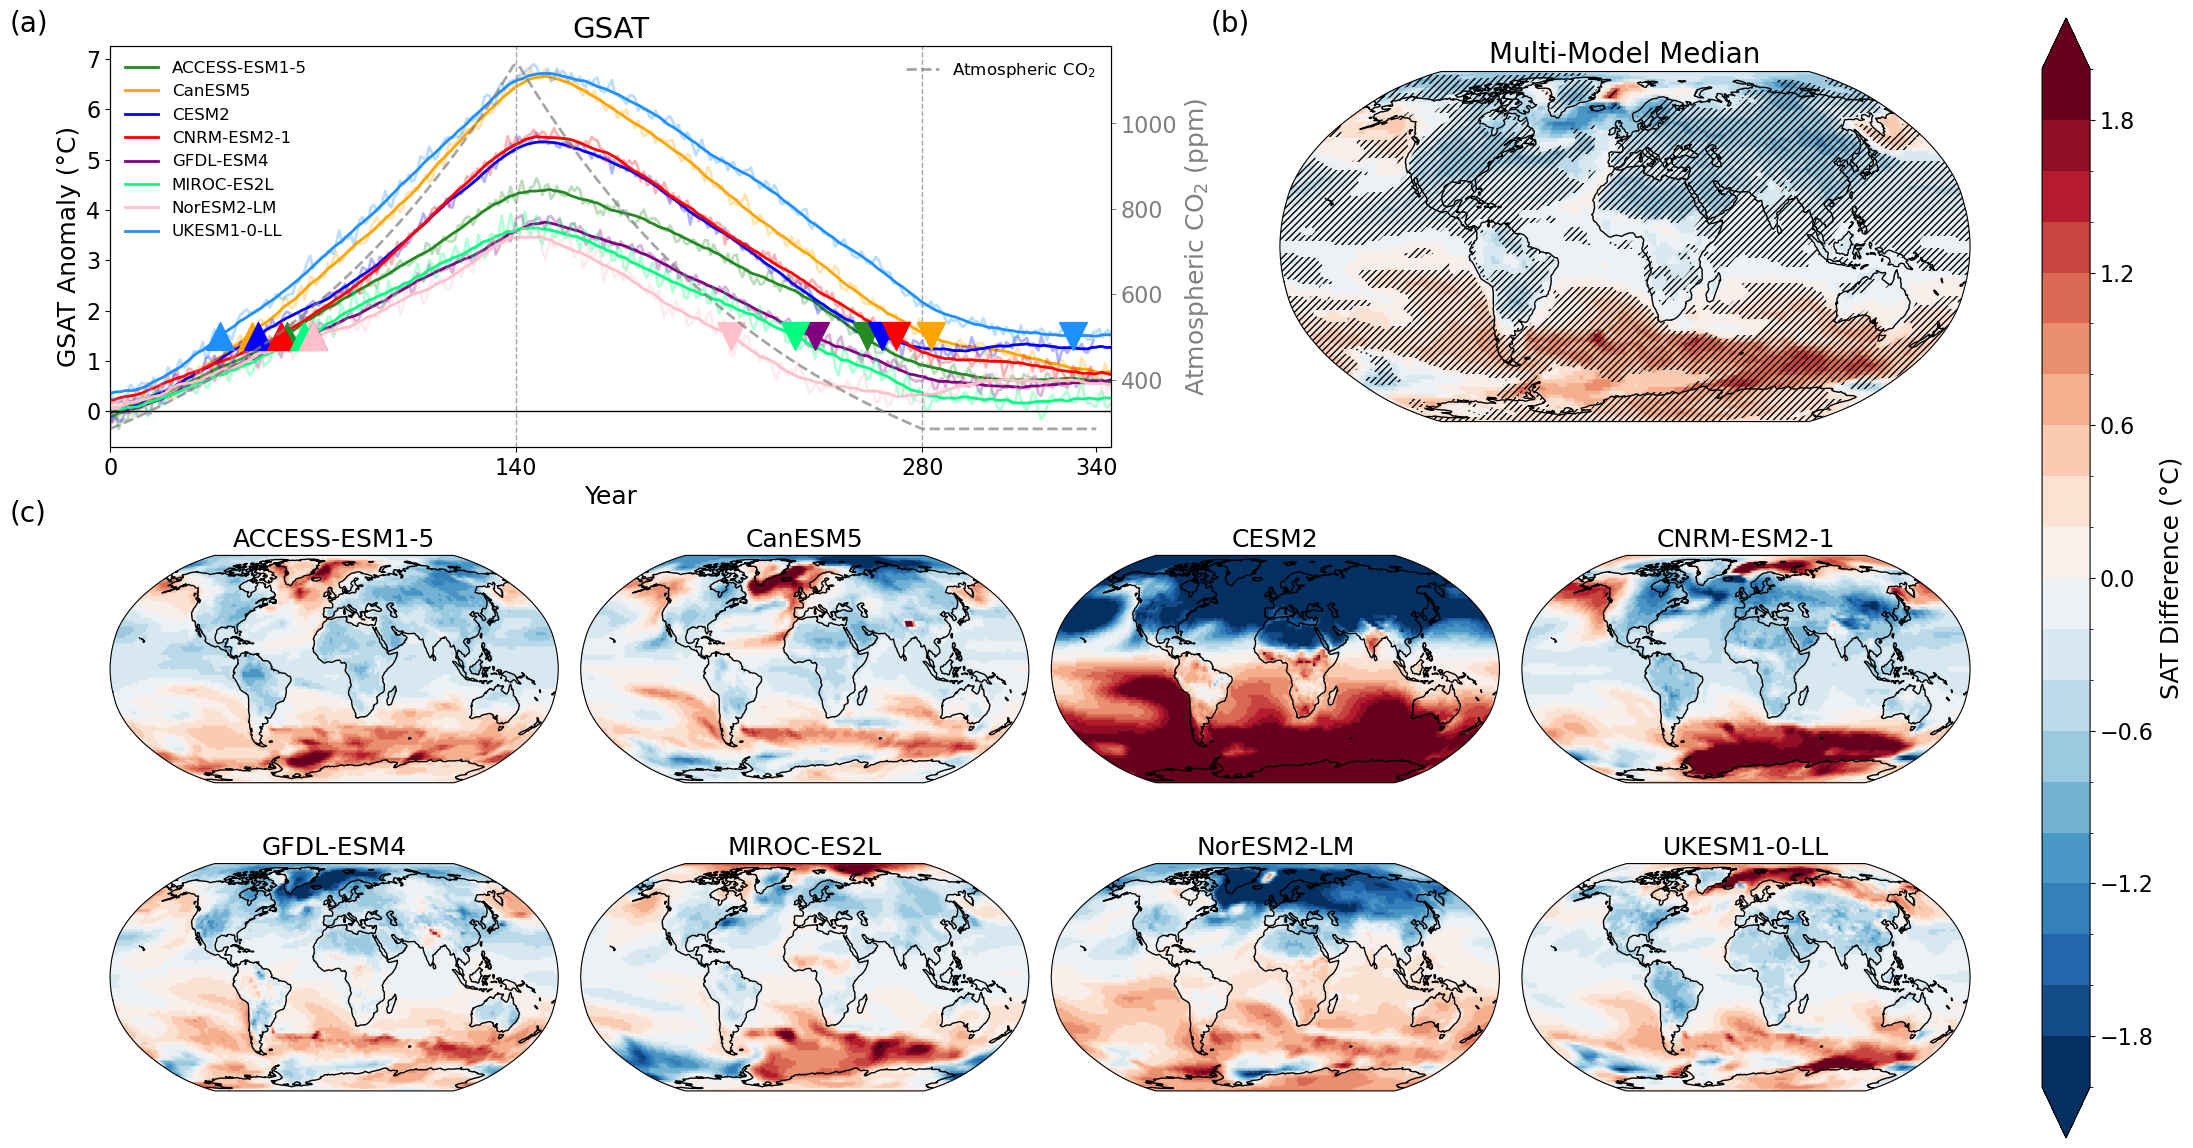

In [15]:
plot_full_figure(
    gsat_da,
    gwl_years,
    sat_diff['Multi-Model Median'],
    1.5,
    sat_diff_agreement,
    np.linspace(-2,2,21),
    sat_diff,
    models
)

[Text(0, 0, '0'),
 Text(20, 0, '20'),
 Text(40, 0, '40'),
 Text(60, 0, '60'),
 Text(80, 0, '80'),
 Text(100, 0, '100'),
 Text(120, 0, '120'),
 Text(140, 0, '140'),
 Text(160, 0, '160'),
 Text(180, 0, '180'),
 Text(200, 0, '200'),
 Text(220, 0, '220'),
 Text(240, 0, '240'),
 Text(260, 0, '260'),
 Text(280, 0, '280'),
 Text(300, 0, '300'),
 Text(320, 0, '320')]

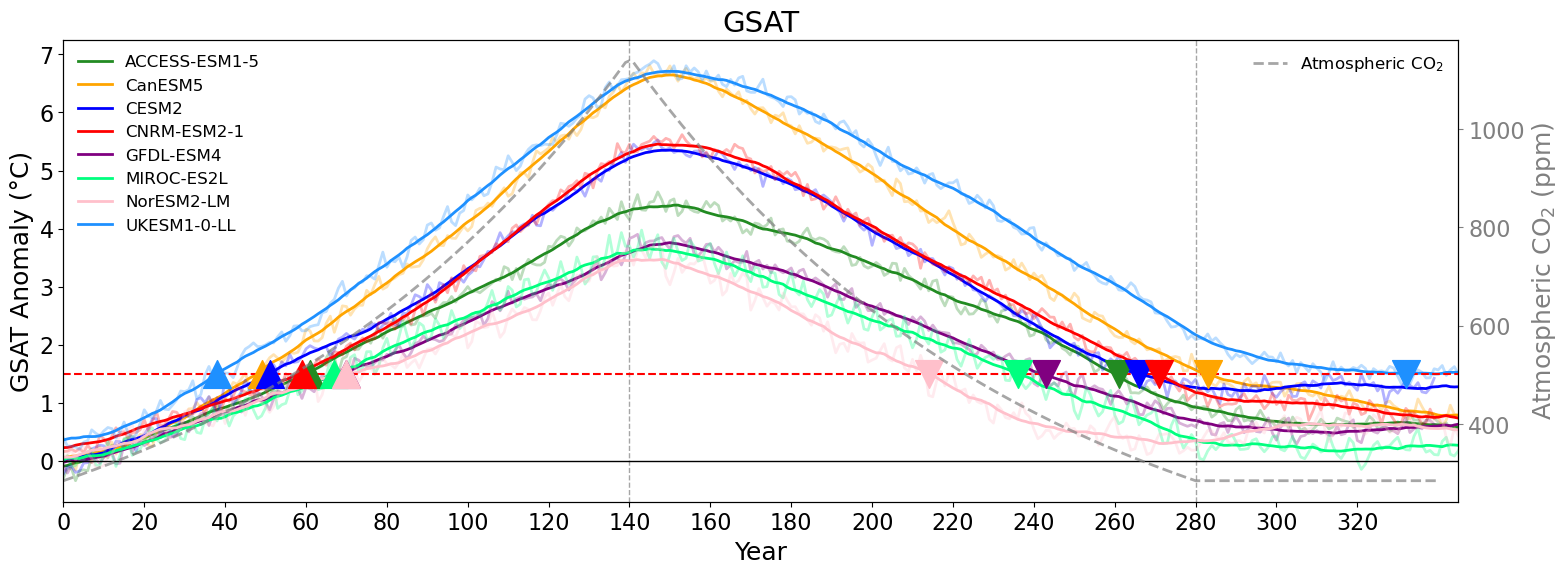

In [82]:
fig, ax1 = plt.subplots(1,1,figsize=(18,6))
plot_gmst_and_gwls(gsat_da,gwl_years, fig, ax1)
ax1.axhline(y=1.5,linestyle='--',color='red')
ax1.set_xticks(list(np.arange(0,340,20)))
ax1.set_xticklabels([str(year) for year in list(np.arange(0,340,20))])

In [84]:
gsat_rolling = {
    model: ds.rolling(year=21,center=True,min_periods=1).mean()
    for model, ds in gsat.items()
}

In [98]:
for model in models:
    da = gsat_rolling[model]
    years = gwl_years[model].sel(gwl=1.5).values
    print(model)
    print(f'ramp_up: {da.sel(year=years[0]).values}')
    print(f'ramp-up - 1: {da.sel(year=years[0]-1).values}')
    print(f'ramp-down: {da.sel(year=years[1]).values}')
    print(f'ramp-down - 1: {da.sel(year=years[1]-1).values}')

ACCESS-ESM1-5
ramp_up: 1.5278861460525277
ramp-up - 1: 1.4822552463792071
ramp-down: 1.4560901371773962
ramp-down - 1: 1.5007874092863007
CanESM5
ramp_up: 1.5513600744323295
ramp-up - 1: 1.4995789775831212
ramp-down: 1.4871503937516908
ramp-down - 1: 1.5006613620084286
CESM2
ramp_up: 1.5071755132138724
ramp-up - 1: 1.4805064491798237
ramp-down: 1.48752579739084
ramp-down - 1: 1.5145809764050626
CNRM-ESM2-1
ramp_up: 1.5186168755659268
ramp-up - 1: 1.4937995219067381
ramp-down: 1.4792646252446342
ramp-down - 1: 1.5065218871221036
GFDL-ESM4
ramp_up: 1.5262455457200097
ramp-up - 1: 1.4899903278248459
ramp-down: 1.4783377088917362
ramp-down - 1: 1.5026139183997156
MIROC-ES2L
ramp_up: 1.5016892187104998
ramp-up - 1: 1.4884100443065365
ramp-down: 1.4949556074118853
ramp-down - 1: 1.5223171932310982
NorESM2-LM
ramp_up: 1.509318756220994
ramp-up - 1: 1.4925756793016374
ramp-down: 1.4908156402443784
ramp-down - 1: 1.5392867248903181
UKESM1-0-LL
ramp_up: 1.5027914902524337
ramp-up - 1: 1.45478757